*Credits: this notebook origin (shared under MIT license) belongs to [ML course at ICL](https://github.com/yandexdataschool/MLatImperial2020) held by Yandex School of Data Analysis. Special thanks to the course team for making it available online.*

## week0_05: Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

Probably it will be around 50%

We'll start from writing a class to select the best features:

In [3]:
class FeatureSelector:
    def __init__(self, num_features):
        self.n = num_features # number of best features to select

    def fit(self, X, y):
        # Select features that describe the targets best, i.e. have
        # highest correlation with them:
        covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
        self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

    def transform(self, X):
        return X[:,self.best_feature_ids]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.97


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

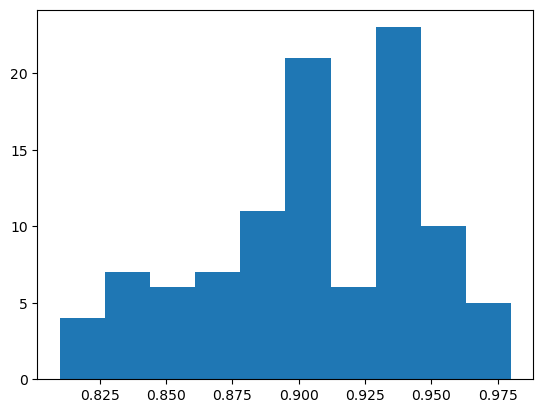

In [5]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
    # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    # Feature selection:
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)

    # Simple classification model
    model = LinearSVC()

  # Estimatin accuracy using cross-validation:
    return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Can you explain and fix this?

Здесь происходит следующее:
* когда мы выбираем лучшие sample-ы, тогда модель просматривает всю тренировочную выборку, следовательно она выбирает лучшие sample-ы среди всей выборки и тренируется на ней
* когда мы применяем кроссвалидацию, то в валидационные данные может попасть та часть sample-ов, на которой мы уже обучились и в большинстве случаев такое происходит
* поэтому такой большой скор получается

In [6]:
# It's dangerous to go alone. Take this!
from sklearn.pipeline import Pipeline

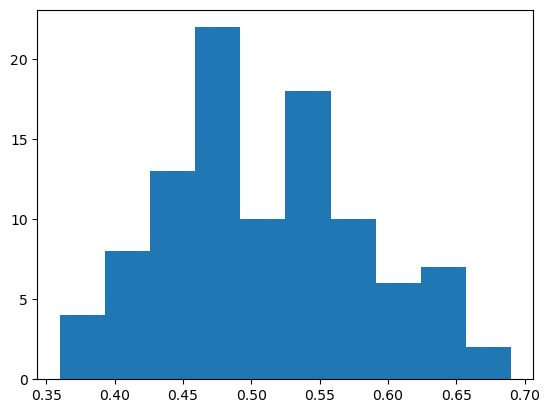

In [7]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
    # Dataset generation
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    # Feature selection:
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)

    # Simple classification model
    model = Pipeline(steps=(('preproc', FeatureSelector(num_features_best)),
                 ('svc', LinearSVC()),)
                )

  # Estimatin accuracy using cross-validation:
    return cross_val_score(model, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

Здесь мы уже использовали pipeline, чтобы избежать утечки данных (data leak)

## Подбор гиперпараметров с помощью RandomizedForestCV

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [14]:
model = Pipeline(steps=(('preproc', FeatureSelector(num_features_best)),
                        ('svc', LinearSVC()),))

param_distr = {
    'svc__C': np.logspace(-1000, 1000)
}

clf = RandomizedSearchCV(model, param_distr, scoring='accuracy', cv=5)

C:\Users\User\anaconda3\envs\Machine-Learning\lib\site-packages\numpy\core\function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


In [15]:
clf.fit(X, y)

C:\Users\User\anaconda3\envs\Machine-Learning\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\Machine-Learning\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\Machine-Learning\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\User\anaconda3\envs\Machine-Learning\lib\site-packages\sklearn\svm\_classes.py"

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=(('preproc',
                                              <__main__.FeatureSelector object at 0x00000288E275F370>),
                                             ('svc', LinearSVC()))),
                   param_distributions={'svc__C': array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000,...
       0.00000000e+000, 7.54312006e-307, 4.94171336e-266, 3.23745754e-225,
       2.12095089e-184, 1.38949549e-143, 9.10298178e-103, 5.96362332e-062,
       3.90693994e-021, 2.55954792e+020, 1.67683294e+061, 1.09854114e+102,
       7.19685673e+142, 4.71486636e+183, 3.08884360e+224, 2.02358965e+265,
       1.32571137e+306,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf])},
                   scoring='accuracy')

In [16]:
print(clf.best_params_)
print(clf.best_estimator_)
print(clf.best_score_)

{'svc__C': inf}
Pipeline(steps=[('preproc',
                 <__main__.FeatureSelector object at 0x00000288E275FE80>),
                ('svc', LinearSVC(C=inf))])
0.5800000000000001
